# 3D Heat Equation simulation using FenicsX
## Author: Souvik Roy

In [3]:
import matplotlib as mpl
import pyvista
import ufl
import numpy as np
from petsc4py import PETSc
from mpi4py import MPI
from dolfinx import fem, mesh, io, plot
from dolfinx.fem.petsc import assemble_vector, assemble_matrix, create_vector, apply_lifting, set_bc


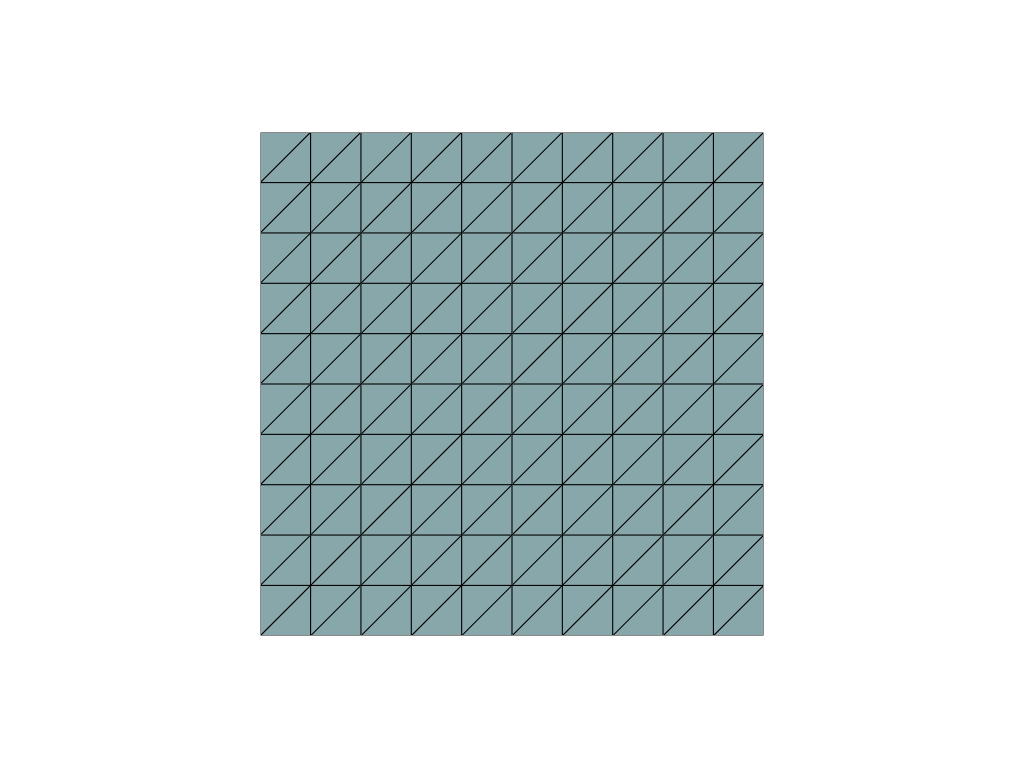

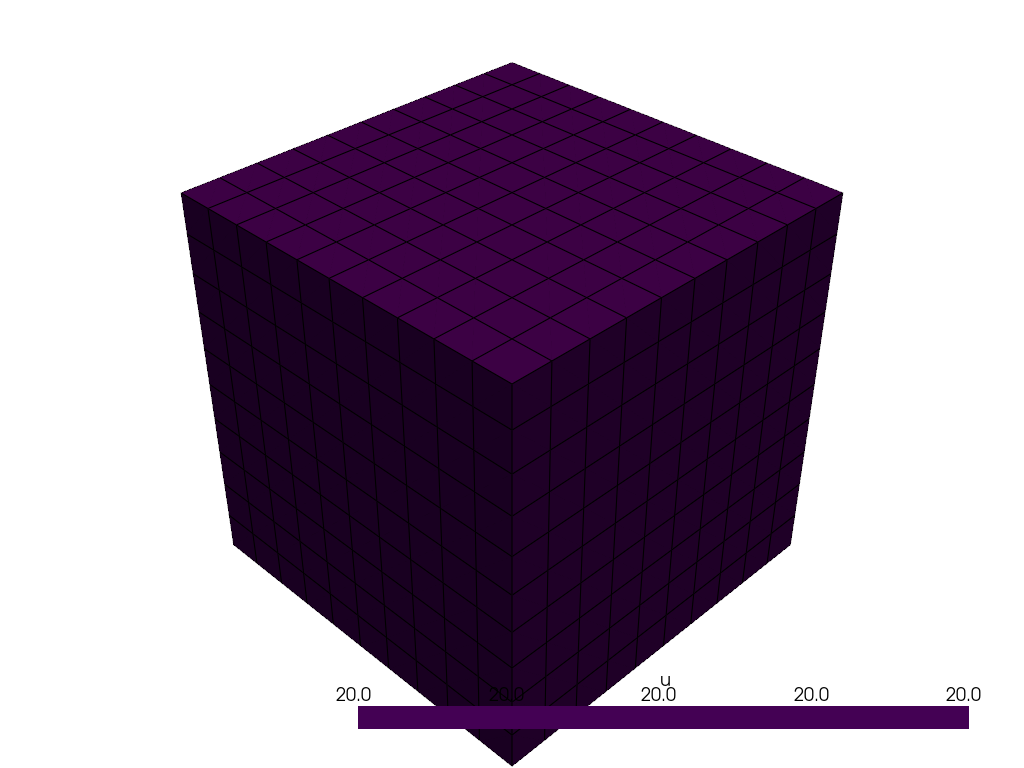

In [31]:
# Physical Dimensions
Lx,Ly,Lz = 1.0, 1.0, 1.0

# Mesh
nx, ny, nz = 10, 10, 10

domain = mesh.create_box(MPI.COMM_WORLD, 
                         [np.array([0, 0, 0]), np.array([Lx, Ly, Lz])], 
                         [nx, ny, nz], 
                         mesh.CellType.hexahedron)

# Function Space
V = fem.functionspace(domain, ("CG", 1))
# xdmf = io.XDMFFile(MPI.COMM_WORLD, "fundamentals_mesh.xdmf", "w")
# xdmf.write_mesh(domain)
u_n = fem.Function(V)

# Initial Condition
u_n.interpolate(lambda x: np.full(x.shape[1], 20))
# xdmf.write_function(u_n, 0.0)
# Boundary facets
def top_surface(x):
    return np.isclose(x[2], Lz)

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

# Split into top and others
top_facets = mesh.locate_entities_boundary(domain, fdim, top_surface)
other_facets = np.setdiff1d(boundary_facets, top_facets)

# Create Dirichlet BCs
# Top = 100
u_top = fem.Function(V)
u_top.interpolate(lambda x: np.random.uniform(30,100, size=x.shape[1]))
dofs_top = fem.locate_dofs_topological(V, fdim, top_facets)
bc_top = fem.dirichletbc(u_top, dofs_top)

# Others = 20
u_other = fem.Function(V)
u_other.interpolate(lambda x: np.full(x.shape[1], 20.0))
dofs_other = fem.locate_dofs_topological(V, fdim, other_facets)
bc_other = fem.dirichletbc(u_other, dofs_other)
bcs = [bc_top, bc_other]

dt = 0.0006858710562414266
T = dt *100
# diffusion
def diffusion(T):
    return 1.0 + 2.0 / (1 + ufl.exp(-10*(T - 0.5)))

# Visualization
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)

u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = u_n.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)

# if not pyvista.OFF_SCREEN:
u_plotter.show()
k = diffusion(u_n)
u, v = ufl.TrialFunction(V),  ufl.TestFunction(V)
# dx = ufl.dx(domain=V.mesh)  # Explicit domain!
a = u*v*ufl.dx + dt * k* ufl.dot(ufl.grad(u),ufl.grad(v)) * ufl.dx
L = u_n*v*ufl.dx
from dolfinx.fem.petsc import LinearProblem
problem = LinearProblem(a, L, bcs= bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

t = 0.0

plotter = pyvista.Plotter(shape= (1,3), off_screen=True)
plotter.open_gif("u_field_slice.gif")
while t<T:
    t+= dt
    u_n.x.array[:] = problem.solve().x.array[:]
    u_top.interpolate(lambda x: np.random.uniform(30,100, size=x.shape[1]))
    bc_top = fem.dirichletbc(u_top, dofs_top)
    bcs = [bc_top, bc_other]
    #xdmf.write_function(u_n, t)
    #print(u_n.x.array)
    # print(problem.solve().x.array)
    u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
    u_grid.point_data["u"] = u_n.x.array.real
    u_grid.set_active_scalars("u")
    slice_xz = u_grid.slice(normal='y', origin=(0, 0.5, 0))

    # # Plot and write frame
    # plotter.clear()
    # plotter.add_mesh(slice_xz, show_edges=False, cmap="jet", clim=(0, 100))
    # plotter.view_xz()
    # plotter.write_frame()
    # Create slices
    slice_xz = u_grid.slice(normal='y', origin=(0, 0.5, 0))  # Mid-Y
    slice_xy = u_grid.slice(normal='z', origin=(0, 0, 0.9))  # Mid-Z
    input_slice = u_grid.slice(normal='z', origin=(0, 0, 1))

    # Clear previous frame
    plotter.clear()

    # Left subplot (XZ slice)
    plotter.subplot(0, 0)
    plotter.add_text(f"t = {t:.1f} hr\nXZ Slice", font_size=10)
    plotter.add_mesh(slice_xz, show_edges=False, cmap="jet", clim=(0, 100))
    plotter.view_xz()

    # Right subplot (XY slice)
    plotter.subplot(0, 1)
    plotter.add_text("XY Slice", font_size=10)
    plotter.add_mesh(slice_xy, show_edges=False, cmap="jet", clim=(0, 100))
    plotter.view_xy()

    # Input slice
    plotter.subplot(0, 2)
    plotter.add_text("Input Slice", font_size=10)
    plotter.add_mesh(input_slice, show_edges=False, cmap="jet", clim=(0, 100))
    plotter.view_xy()

    # Save frame
    plotter.write_frame()


plotter.close()

#xdmf.close()

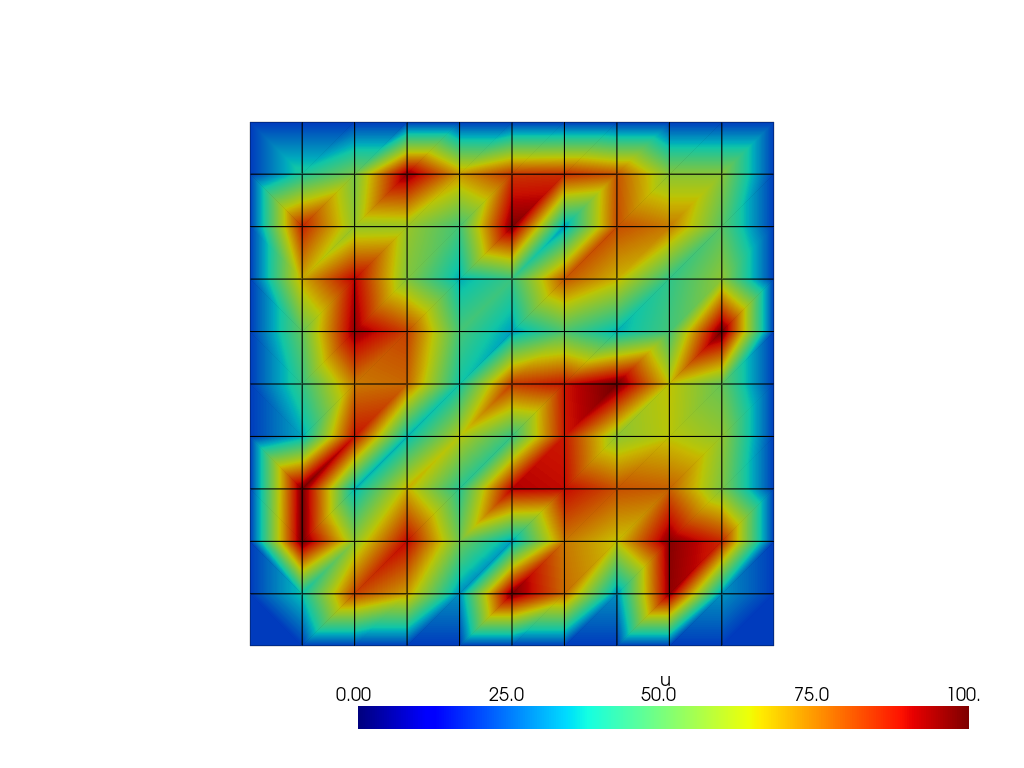

In [26]:
# # Create the unstructured grid
# u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
# u_grid.point_data["u"] = u_n.x.array.real
# u_grid.set_active_scalars("u")

# # Slice at y = 0.5 (mid-Y)
# slice_xz = u_grid.slice(normal='y', origin=(0, 0.5, 0))

# # Plot the slice
# u_plotter = pyvista.Plotter()
# u_plotter.add_mesh(slice_xz, show_edges=True, cmap="viridis")
# u_plotter.view_xz()
# u_plotter.show()
# Create the unstructured grid
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = u_n.x.array.real
u_grid.set_active_scalars("u")

# Slice at y = 0.5 (mid-Y)
slice_xz = u_grid.slice(normal='z', origin=(0, 0, 1))

# Plot the slice with fixed color limits
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(slice_xz, show_edges=True, cmap="jet", clim=(0, 100))
u_plotter.view_xy()
u_plotter.show()


In [9]:
u_n.x.array

array([20., 20., 20., ..., 20., 20., 20.], shape=(1331,))

In [7]:
if not pyvista.OFF_SCREEN:
    plotter.show()

NameError: name 'plotter' is not defined

In [7]:
for i in range(num_steps):
    t += dt

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, linear_form)

    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.x.petsc_vec)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array

    # Write solution to file
    xdmf.write_function(uh, t)
    # Update plot
    new_warped = grid.warp_by_scalar("uh", factor=1)
    warped.points[:, :] = new_warped.points
    warped.point_data["uh"][:] = uh.x.array
    plotter.write_frame()
plotter.close()
xdmf.close()